In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime
from scipy import stats
import seaborn as sns

In [2]:
crimes_2012 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', sep=',', error_bad_lines=False)
# crimes_2012.drop(crimes_2012.columns[[0, 2, 5]], axis=1)

### preprocessing

In [3]:
crimes_2012.apply(lambda x: sum(x.isnull()))
crimes_2012.apply(lambda x: len(x.unique()))

Unnamed: 0              1456714
ID                      1456714
Case Number             1456599
Date                     582146
Block                     32774
IUCR                        365
Primary Type                 33
Description                 342
Location Description        143
Arrest                        2
Domestic                      2
Beat                        302
District                     25
Ward                         51
Community Area               79
FBI Code                     26
X Coordinate              67715
Y Coordinate             111556
Year                          6
Updated On                  959
Latitude                 368077
Longitude                367943
Location                 368287
dtype: int64

In [3]:
crimes_2012.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimes_2012.drop(['Unnamed: 0','Case Number','IUCR','FBI Code','Updated On','Location',
                  'X Coordinate','Y Coordinate','Location'], inplace = True, axis = 1)
crimes_2012 = crimes_2012.dropna(axis = 0, how = 'any')

## date conversion
crimes_2012.Date = pd.to_datetime(crimes_2012.Date, format = '%m/%d/%Y %I:%M:%S %p')
crimes_2012.index = pd.DatetimeIndex(crimes_2012.Date)

In [4]:
crimes_2012['Primary Type'] = pd.Categorical(crimes_2012['Primary Type'])
crimes_2012['Description'] = pd.Categorical(crimes_2012['Description'])
crimes_2012['Location Description'] = pd.Categorical(crimes_2012['Location Description'])

### EDA

let's visualize different types of crimes per month

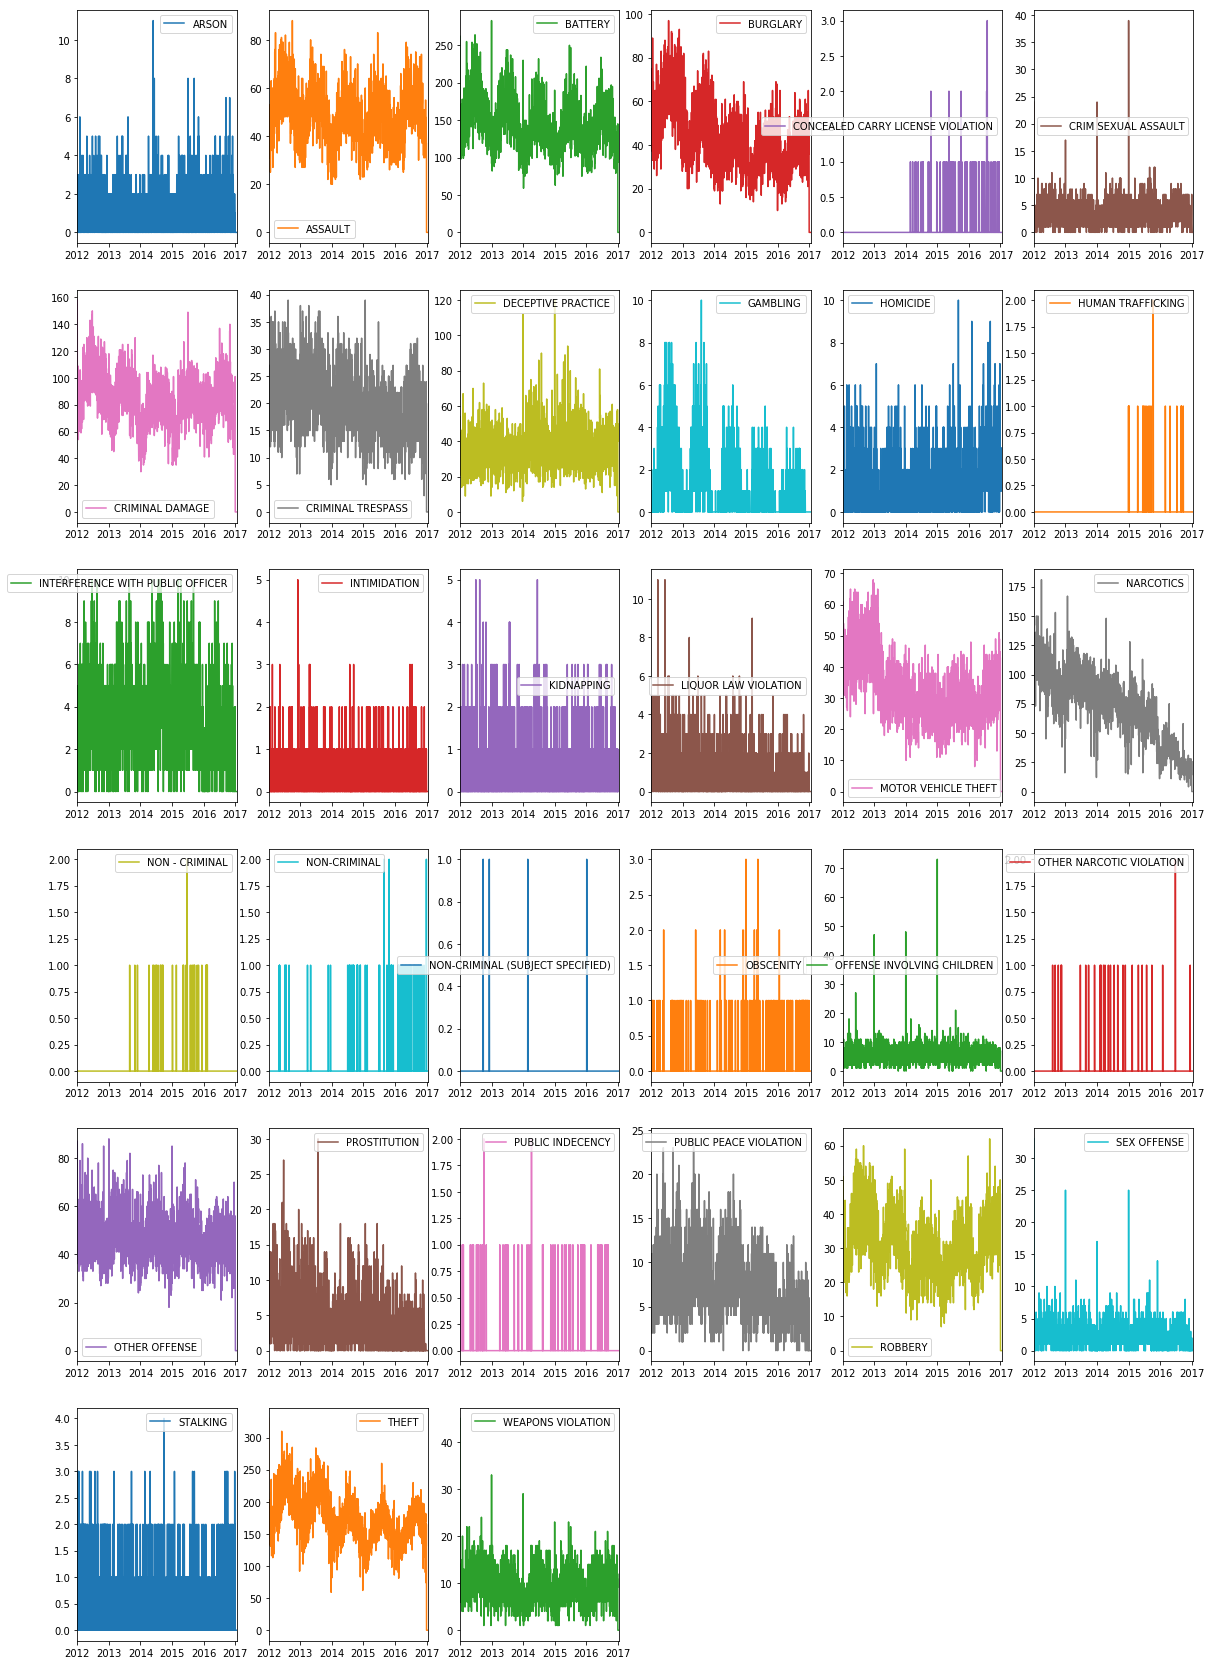

In [5]:
Crime_Data_date = crimes_2012.pivot_table('ID', aggfunc = np.size, columns = 'Primary Type', 
                                         index = crimes_2012.index.date, fill_value = 0)
Crime_Data_date.index = pd.DatetimeIndex(Crime_Data_date.index)

Plot = Crime_Data_date.plot(figsize = (20,30), subplots = True, layout = (6,6),
                                  sharex = False, sharey = False)
plt.show()

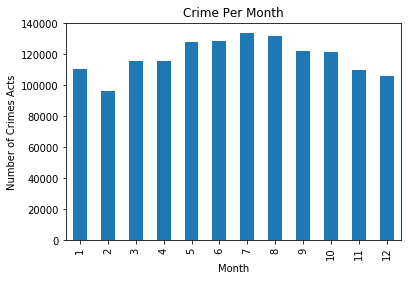

In [6]:
#make graph of crimes per month
crimes_2012.groupby([crimes_2012.index.month]).size().plot.bar()
plt.title('Crime Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Acts')
plt.show()

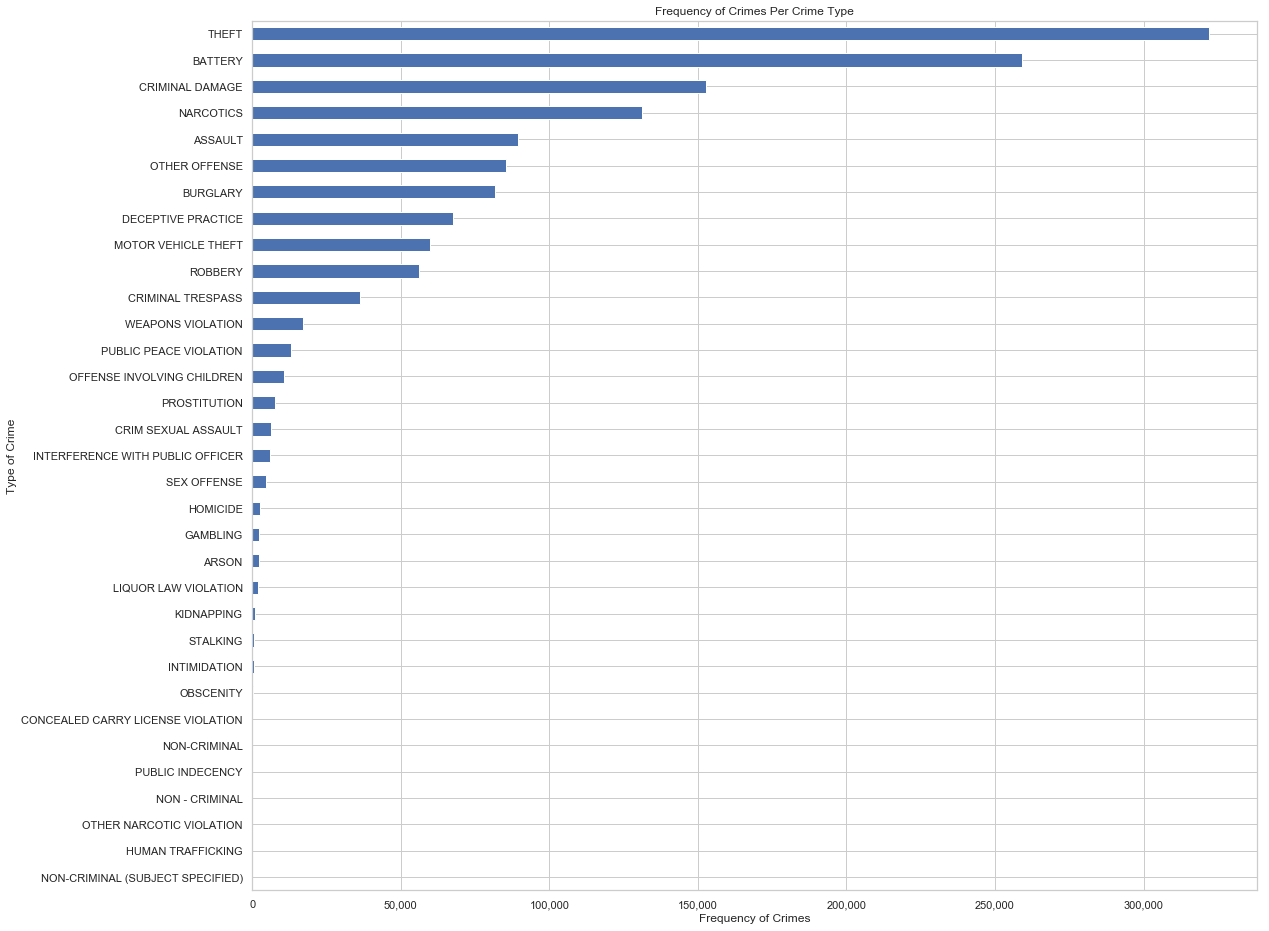

In [40]:
## most prevalent crimes that occured in Chicago

crime_type_df = crimes_2012['Primary Type'].value_counts(ascending=True)

## Some formatting to make it look nicer
fig=plt.figure(figsize=(18, 16))
plt.title("Frequency of Crimes Per Crime Type")
plt.xlabel("Frequency of Crimes")
plt.ylabel("Type of Crime")
ax = crime_type_df.plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


#plot of the relatives amounts of each type of crime
# plt.figure(figsize = (8,12))
# crimes_2012.groupby(crimes_2012['Primary Type']).size().sort_values(ascending = True).plot(kind = 'barh')
# plt.xlabel('Number of Crimes Committed')
# plt.show()


In [42]:
#extract year data for each crime


Groups = crimes_2012.groupby(crimes_2012['Primary Type'])
Groups = dict(list(Groups))
Keys = list(Groups.keys())

# for key in Keys:
#     plt.figure(figsize = (4,4))
#     plt.scatter(Groups[key].Longitude, Groups[key].Latitude, marker = '.')
#     plt.ylim(41.6,42.1)
#     plt.xlim(-88,-87.4)
#     plt.title(key)
#     plt.ylabel('Latitude')
#     plt.xlabel('Longitude')
#     plt.show()



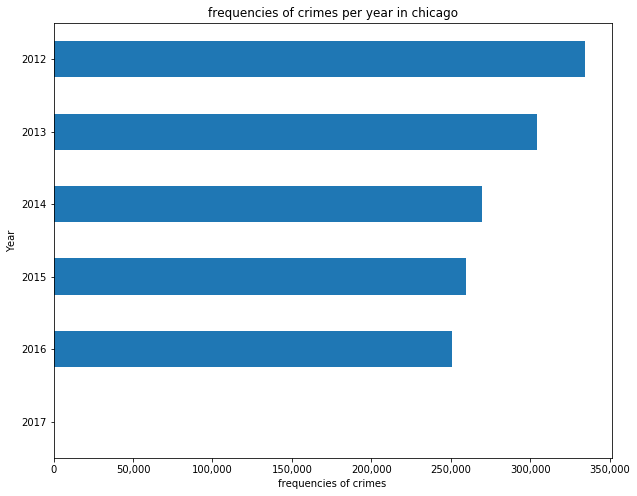

In [8]:
### crime in each year
crimes_2012['Year'].isnull().values.any()
crimes_2012['Year'].value_counts()

## visualize it

crimes_2012_by_year = crimes_2012['Year'].value_counts(ascending=True)
fig = plt.figure(figsize=(10,8))
plt.title("frequencies of crimes per year in chicago")
plt.xlabel("frequencies of crimes")
plt.ylabel("Year")
ax=crimes_2012_by_year.plot(kind="barh")
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


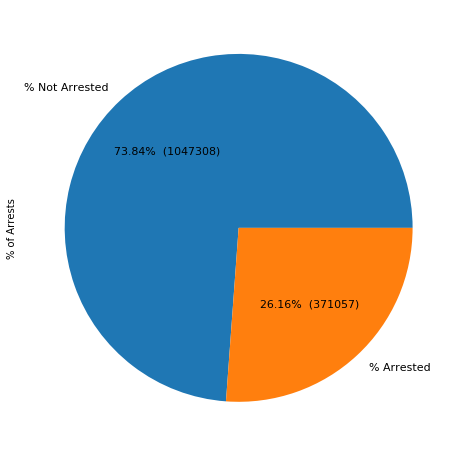

In [9]:
## visualize successful arrest type

crimes_2012['Arrest'].isnull().values.any()

arrest_df = crimes_2012['Arrest'].value_counts()
arrest_percent = (arrest_df / crimes_2012['Arrest'].sum()) * 100 
arrest_percent.rename("% of Arrests",inplace=True)
arrest_percent.rename({True: '% Arrested', False: '% Not Arrested'},inplace=True)


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

## show it with pieplot
arrest_percent.plot.pie(fontsize=11,
                       autopct=make_autopct(crimes_2012['Arrest'].value_counts()), figsize=(8, 8))

In [10]:
## Group dataset by year and arrests
arrest_per_year = crimes_2012.groupby('Year')['Arrest'].value_counts().rename('Counts').to_frame()
arrest_per_year['Percentage'] = (100 * arrest_per_year / arrest_per_year.groupby(level=0).sum())
arrest_per_year.reset_index(level=[1],inplace=True)

arrest_per_year.head()

,Arrest,Counts,Percentage
Year,,,
2012,False,243957,72.954303
2012,True,90440,27.045697
2013,False,218225,71.721547
2013,True,86042,28.278453
2014,False,191291,71.025029


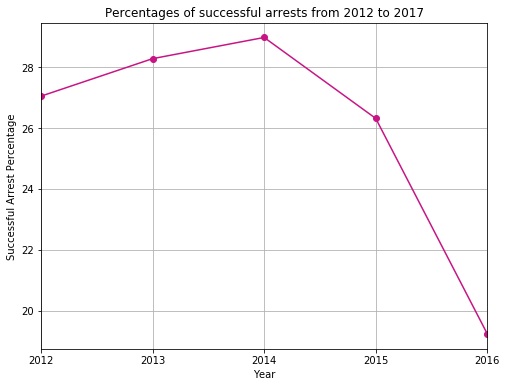

In [11]:
## Create a line plot for percentages of successful arrests over time (2001 to present)
line_plot = arrest_per_year[arrest_per_year['Arrest'] == True]['Percentage']

## Configure line plot to make visualizing data cleaner
labels = line_plot.index.values
fig=plt.figure(figsize=(8, 6))
plt.title('Percentages of successful arrests from 2012 to 2017')
plt.xlabel("Year")
plt.ylabel("Successful Arrest Percentage")
plt.xticks(line_plot.index, line_plot.index.values)

line_plot.plot(grid=True, marker='o', color='mediumvioletred')


#### visualize top 10 crime type

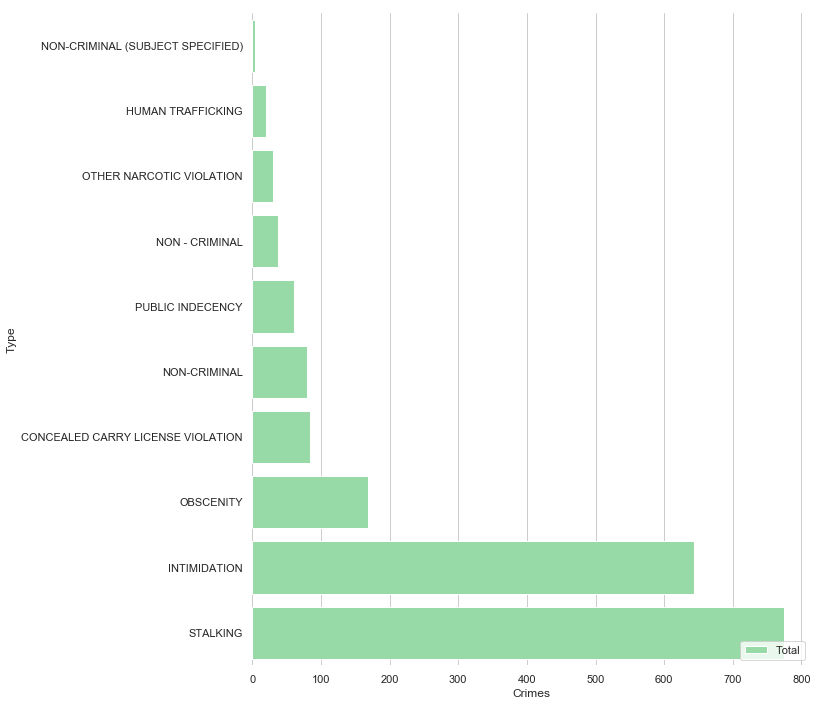

In [34]:
## crime EDA analysis
p_df = crimes_2012[['Primary Type']]

crime_stats = pd.DataFrame(p_df.groupby('Primary Type').size().sort_values(ascending=True).rename('counts').reset_index())
crime_stats.head()

## 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 12))
sns.set_color_codes("pastel")
sns.barplot(x="counts", y="Primary Type", data=crime_stats.iloc[:10, :], label = "Total", color= "g")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="Crimes", ylabel="Type")
sns.despine(left=True, bottom=True)
plt.show()

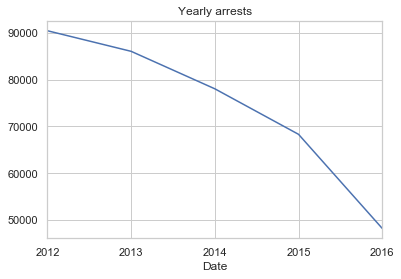

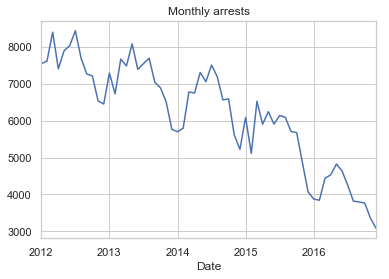

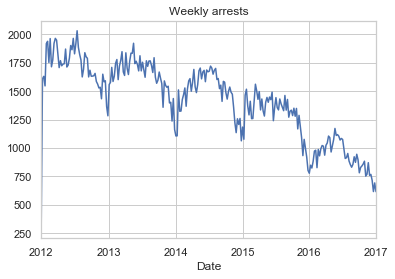

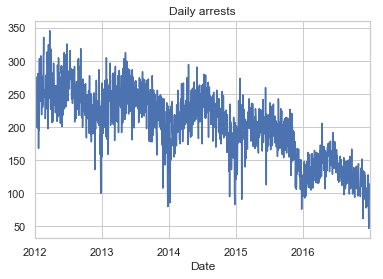

In [37]:
arrest_yearly = crimes_2012[crimes_2012['Arrest'] == True]['Arrest']

plt.subplot()
arrest_yearly.resample('A').sum().plot()
plt.title('Yearly arrests')
plt.show()

arrest_yearly.resample('M').sum().plot()
plt.title('Monthly arrests')
plt.show()

arrest_yearly.resample('W').sum().plot()
plt.title('Weekly arrests')
plt.show()

arrest_yearly.resample('D').sum().plot()
plt.title('Daily arrests')
plt.show()
plt.show()

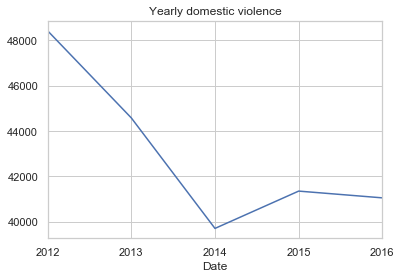

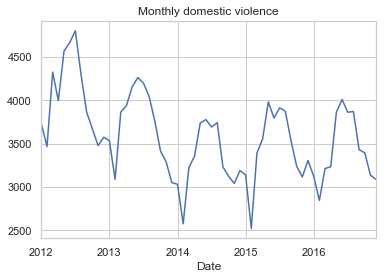

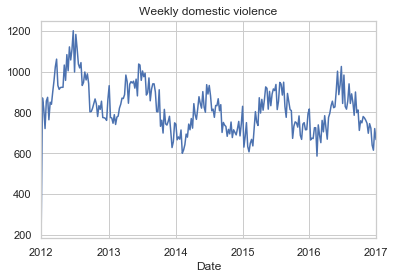

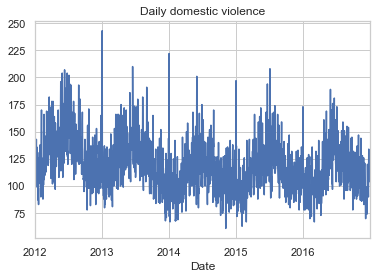

In [38]:
## 
domestic_yearly = crimes_2012[crimes_2012['Domestic'] == True]['Domestic']

plt.subplot()
domestic_yearly.resample('A').sum().plot()
plt.title('Yearly domestic violence')
plt.show()


domestic_yearly.resample('M').sum().plot()
plt.title('Monthly domestic violence')
plt.show()


domestic_yearly.resample('W').sum().plot()
plt.title('Weekly domestic violence')
plt.show()

domestic_yearly.resample('D').sum().plot()
plt.title('Daily domestic violence')
plt.show()
plt.show()

#### crime statistics by districts

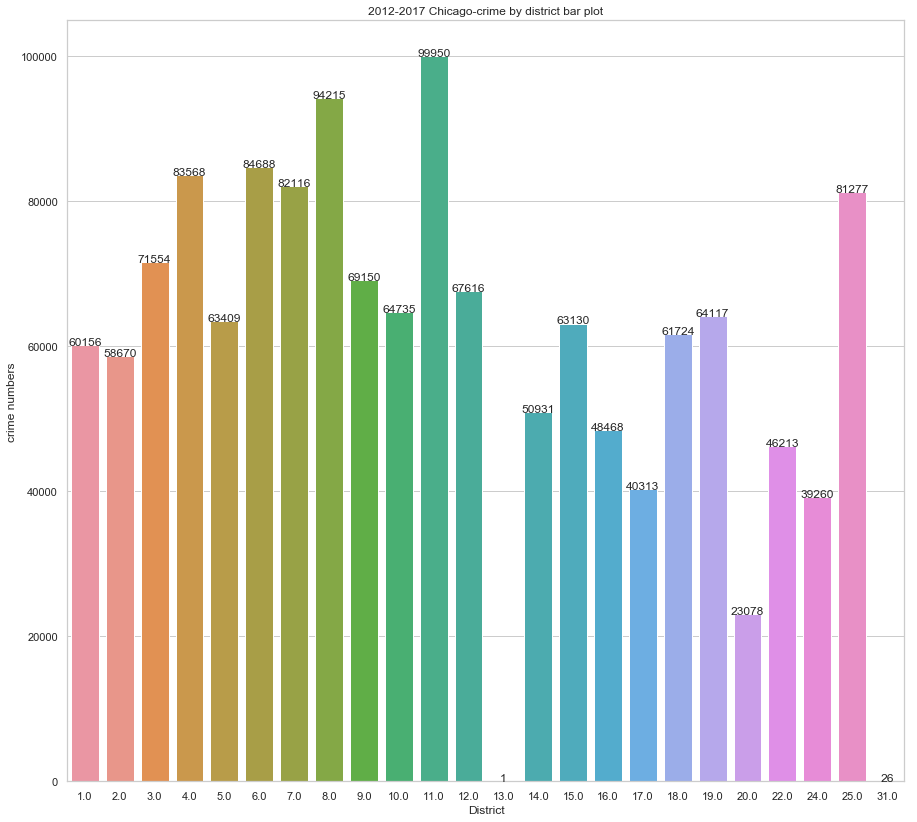

In [95]:
districts = crimes_2012.groupby(by='District')
dist_cnt = districts.count()
dist_df = pd.DataFrame(dist_cnt.iloc[:, 0])
# dist_df.rename({'ID':'crime numbers'}, axis=1)

plt.figure(figsize=(15,14))
plt.title(r'2012-2017 Chicago-crime by district bar plot')
p1=sns.barplot(x=dist_df.index,y='ID',data=dist_df)
x=np.arange(dist_df.index.shape[0])
y=np.array(list(dist_df['ID']))
for i,j in zip(x,y):
    plt.text(i,j+0.05,'%d'%j,ha='center')
else:
    pass

plt.xlabel('District')
plt.ylabel('crime numbers')
p1fig=p1.get_figure()
plt.show()

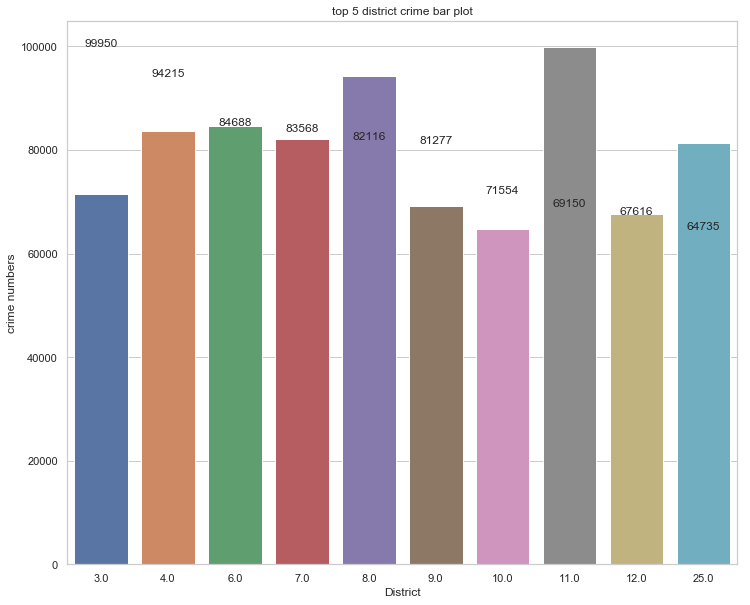

In [96]:
## select top five district by overall crime numbers
dist_df = dist_df.sort_values(by = 'ID', ascending=False)
dist_top5 = dist_df.iloc[0:10, :]

plt.figure(figsize=(12,10))
plt.title(r'top 5 district crime bar plot')
p2=sns.barplot(x=dist_top5.index,y='ID',data=dist_top5)
x=np.arange(dist_top5.index.shape[0])
y=np.array(list(dist_top5['ID']))
for i,j in zip(x,y):
    plt.text(i,j+0.05,'%d'%j,ha='center')
else:
    pass

plt.xlabel('District')
plt.ylabel('crime numbers')
p2fig=p2.get_figure()
plt.show()

### simple linear regression for crime rates

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


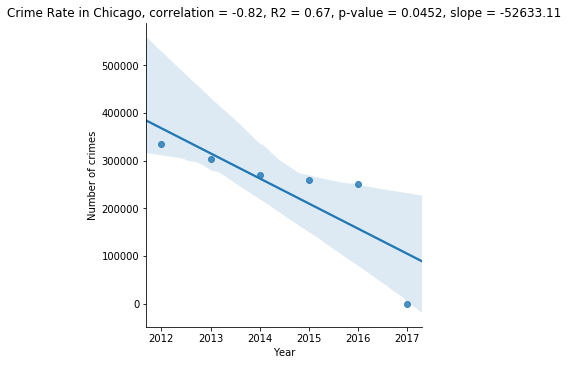

In [9]:
df = crimes_2012.groupby('Year')[['Primary Type']].count().reset_index()

#calculating regression parameters 
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df.Year, df['Primary Type'])
g=sns.lmplot(x='Year',y='Primary Type',data=df,palette='YlGnBu');
g=(g.set_axis_labels("Year","Number of crimes"));
plt.title("Crime Rate in Chicago, correlation = {:.2f}, R2 = {:.2f}, p-value = {:.4f}, slope = {:.2f}".format(rvalue,rvalue**2,pvalue,slope));

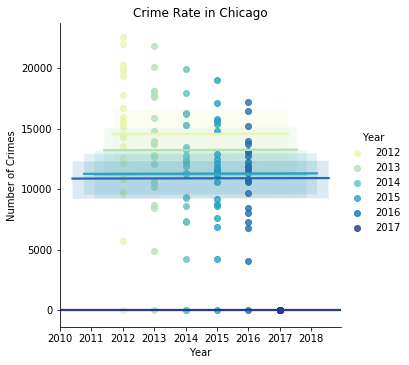

In [13]:
p_df = crimes_2012[['Year','Primary Type', 'District']]
df = p_df.groupby(['Year','District'])[['Primary Type']].count().reset_index();

g=sns.lmplot(x='Year',y='Primary Type',data=df, hue = 'Year',palette='YlGnBu');
g=(g.set_axis_labels("Year","Number of Crimes"));
plt.title("Crime Rate in Chicago");